# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)       
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm) 

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, dendrogram
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.base import clone
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.colors as colors
from matplotlib.colors import Normalize, LinearSegmentedColormap
from shapely.geometry import Point, MultiPoint
from matplotlib.patches import Polygon
from collections import defaultdict
import itertools
from scipy.cluster.hierarchy import linkage

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [26]:
df_behaviour = pickle.load(open("df_behaviour.pkl", 'rb'))

In [135]:
# Creating an assessment table
results_df = pd.DataFrame(columns=["Silhouette_Score", "R2"])
results_df.index.name = 'Method'

# # Initialize an empty DataFrame with explicit data types
# results_df = pd.DataFrame(columns=["Method", "Silhouette_Score", "R2"])
# results_df["Method"] = results_df["Method"].astype(str)
# results_df["Silhouette_Score"] = results_df["Silhouette_Score"].astype(float)
# results_df["R2"] = results_df["R2"].astype(float)
# results_df.set_index('Method', inplace=True)

<a class="anchor" id="clustering">
    
## 3. Clustering
</a>


### Function for plotting R2 for various clustering algorithms

In [28]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def get_r2(df, labels):
    sst = get_ss(df)  
    ssw_labels = df.groupby(labels).apply(get_ss)  
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst 
    return r2
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = get_r2(df, labels)
    return r2_clust

<a class="anchor" id="hierarchical">
    
## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

Hierarchical clustering creates a hierarchy of clusters by either starting with all points in a single cluster and splitting them recursively (divisive) or by starting with each point in its own cluster and merging them (agglomerative). In this project, we are going to use agglomerative clustering.

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### 3.1.1 Defining the best linkage method and the best partitioning method (based on the $R^2$)

The linkage method determines how the distance between clusters is calculated.
- Ward: Minimizes the variance within clusters.
- Complete: Considers the maximum distance between points in two clusters.
- Average: Uses the average distance between points in two clusters.
- Single: Considers the minimum distance between points in two clusters.

The highest $R^2$ in a model implies that this explains better the data. In our case, the best hierarchical linkage is Ward.

In [29]:
# Set up the clusterers

kmeans = KMeans(init='k-means++', n_init=20, random_state=42)
hierarchical = AgglomerativeClustering(metric='euclidean')

In [30]:
# Obtaining the R² scores for each cluster solution on behaviour variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_behaviour, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: 
    r2_scores[linkage] = get_r2_scores(
        df_behaviour, hierarchical.set_params(linkage=linkage))

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.503977,0.380928,0.002104,0.000904,0.469815
3,0.646682,0.382097,0.002411,0.001734,0.607873
4,0.712576,0.576224,0.002533,0.001951,0.669306
5,0.744323,0.594235,0.002619,0.002163,0.703907
6,0.768917,0.595523,0.002731,0.002260,0.735017
7,0.789273,0.644660,0.491852,0.002351,0.759949
8,0.802824,0.648907,0.492803,0.002461,0.776824
9,0.813266,0.654083,0.499502,0.002522,0.785372


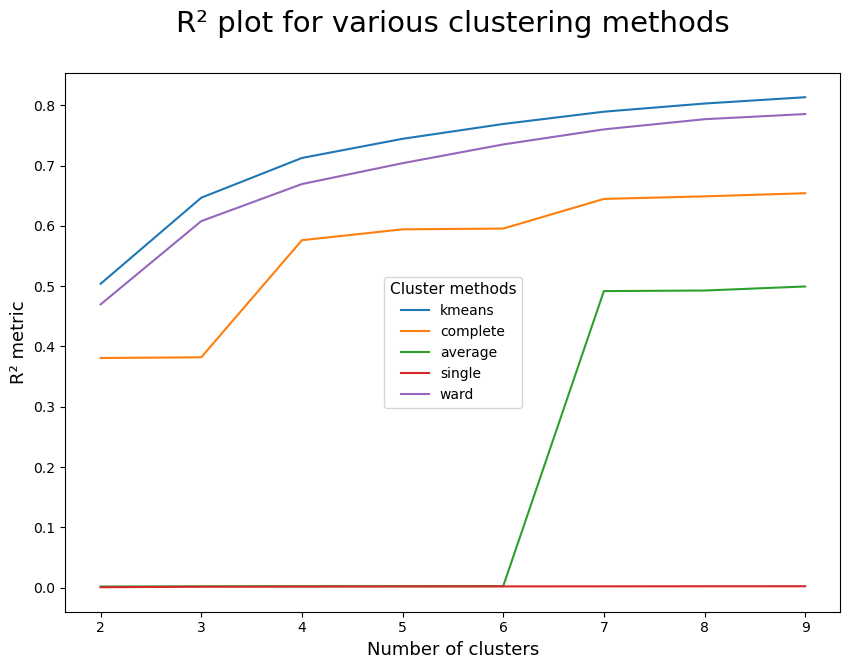

In [31]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("R² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

A dendrogram is a tree-like diagram that is used to illustrate the arrangement of clusters created by hierarchical clustering. It represents how data points (or clusters) are merged step-by-step in the hierarchical clustering process. Dendrograms are useful for the following purposes:

- **Visualizing Cluster Relationships**: It shows how clusters are formed and how closely they are related to one another.
- **Determining the Optimal Number of Clusters**: By cutting the dendrogram at a specific height, it is possible to identify the ideal number of clusters. The height reflects the threshold of similarity or distance.

A dendrogram shows how clusters are merged at each step. By cutting the dendrogram at a specific height, we can define the number of clusters. <br>
Analyzing this dendrogram, we can see a clear separation with 3 clusters, making them potential candidates for the optimal number of clusters.

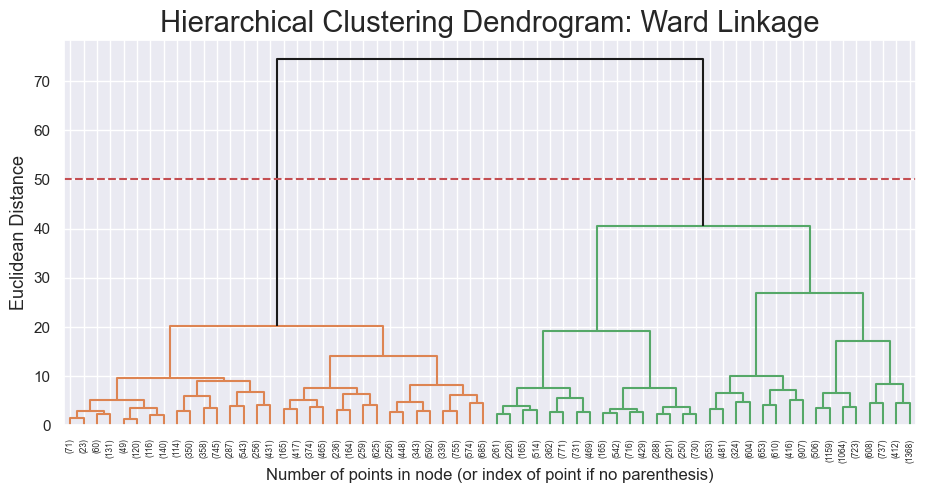

In [32]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_behaviour)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 50
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 3.1.2. Hierarchical Clustering - Silhouette Score 

The **silhouette score** helps us assess how well the data points fit into their assigned clusters. It looks at two things: 

- **Cohesion**: How close points are to others in the same cluster.
- **Separation**: How far points are from clusters that are different.

A **higher silhouette score** (closer to 1) means that the clusters are well-defined, with points tightly grouped together and clearly separated from other clusters. A **lower score** (close to 0) suggests that the clusters may overlap, while a **negative score** indicates points might have been placed in the wrong cluster.

By looking at the silhouette score for different numbers of clusters, we can pick the number of clusters that gives the **best score** that can be seen by the higher silhouete score. The goal is to have the less negatives possible, because positives mean that each point correctly belongs to the cluster that it was assigned to.

For hierarchical clustering, the highest silhouette score was observed with 3 clusters, indicating it is the best choice in this case.

In [33]:
# Compute silhouette score for different n_clusters
for n_clusters in [2, 3, 4]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_behaviour)
    silhouette_avg = silhouette_score(df_behaviour, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 0.39173617432857744
Silhouette Score for 3 clusters: 0.29936331605021255
Silhouette Score for 4 clusters: 0.29696917166138814


### 3.1.4. Hierarchical Clustering - Final Solution

After the analysis of the sillouete score we conclude that the optimal amount of clusters is 2.

In [136]:
# solution with 2 clusters

hc2_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=2)
hc2_labels = hc2_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc2_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

,monetary,product_count,days_as_customer,weekends,daysweek,last_order,diversification
hierarc_labels,,,,,,,
0,0.062094,0.042903,0.152295,0.059529,0.081979,0.578638,0.054516
1,0.126202,0.142087,0.684273,0.147383,0.198064,0.870125,0.183738


In [137]:
r2 = get_r2(df_behaviour, hc2_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, hc2_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_2"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R² Score: 0.4698148915571338
Silhouette Score: 0.39173617432857744


<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>


### 3.2.1.K- Means - Inertia ( Defining the number of cluster)

Inertia measures how well data points fit into clusters by summing the squared distances between points and their nearest cluster centroid (**SSW**). 

- **Lower inertia**: Clusters are more compact, it's better because it means the datapoints are similar to each other.
- **Higher inertia**: Clusters are less defined.

Using the **elbow method**, we plot inertia for 2 to 10 clusters and look for the "elbow"—the point where inertia stops decreasing significantly. This indicates the optimal number of clusters.

We used a range of clusters starting from k=2 because k=1 indicates that a single cluster represents the entire dataset as one group, which is not meaningful for clustering analysis. Starting from k=2 allows us to divide the data into multiple groups and ensure more interpretable results.

Observing the following Inertia plot, we conclude that the optimal number of clusters is 2. We will investigate this further with other methods.

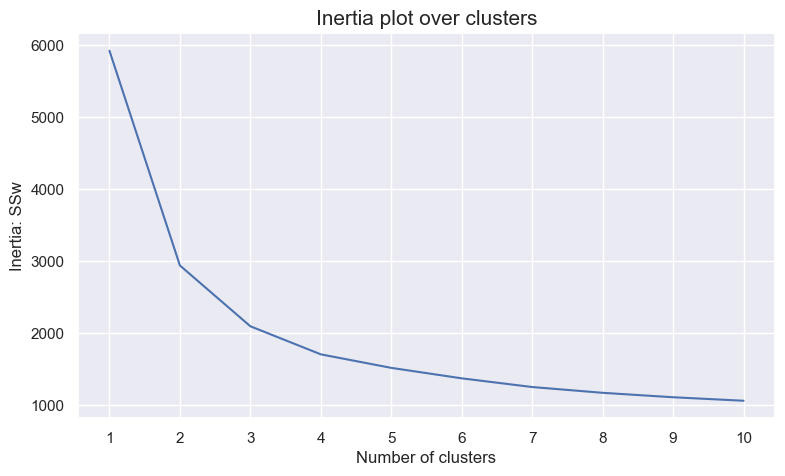

In [36]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_behaviour)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

### 3.2.2. K- Means - Silhouete Score (Defining the number of clusters)

As we saw previously, the silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters. By computing silhouette scores for different numbers of clusters, we can determine the best number of clusters. <br>

The highest silhouette coeficient was obtained with 2 clusters, as it's possible to see.

For n_clusters = 2, the average silhouette_score is : 0.41840381746375466
For n_clusters = 3, the average silhouette_score is : 0.36393265800760005
For n_clusters = 4, the average silhouette_score is : 0.32201676826379494
For n_clusters = 5, the average silhouette_score is : 0.3036573319739752
For n_clusters = 6, the average silhouette_score is : 0.2972804593447143
For n_clusters = 7, the average silhouette_score is : 0.26245366941831483


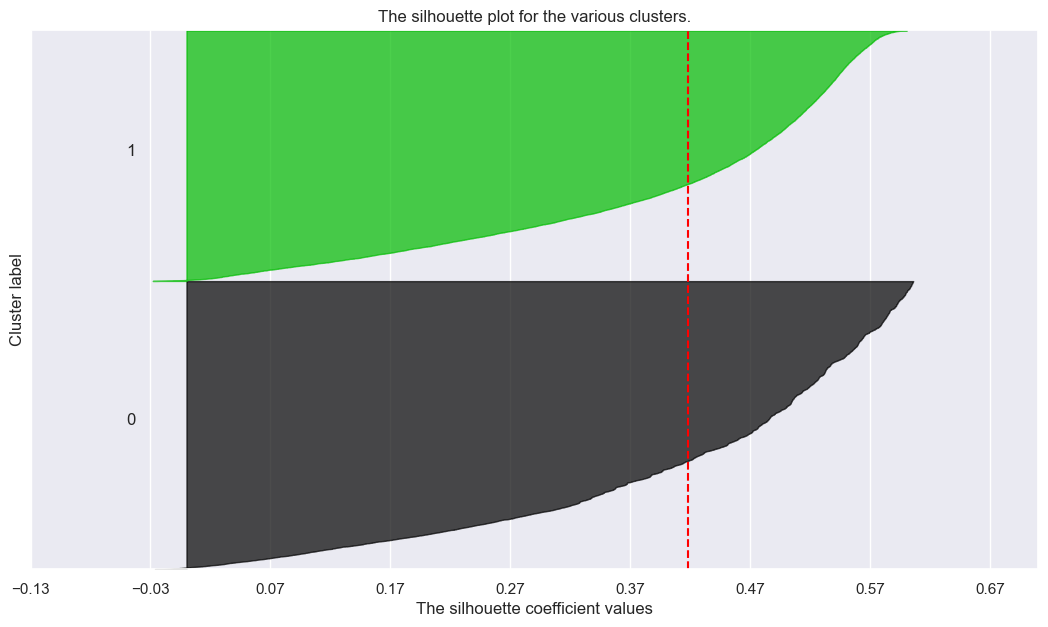

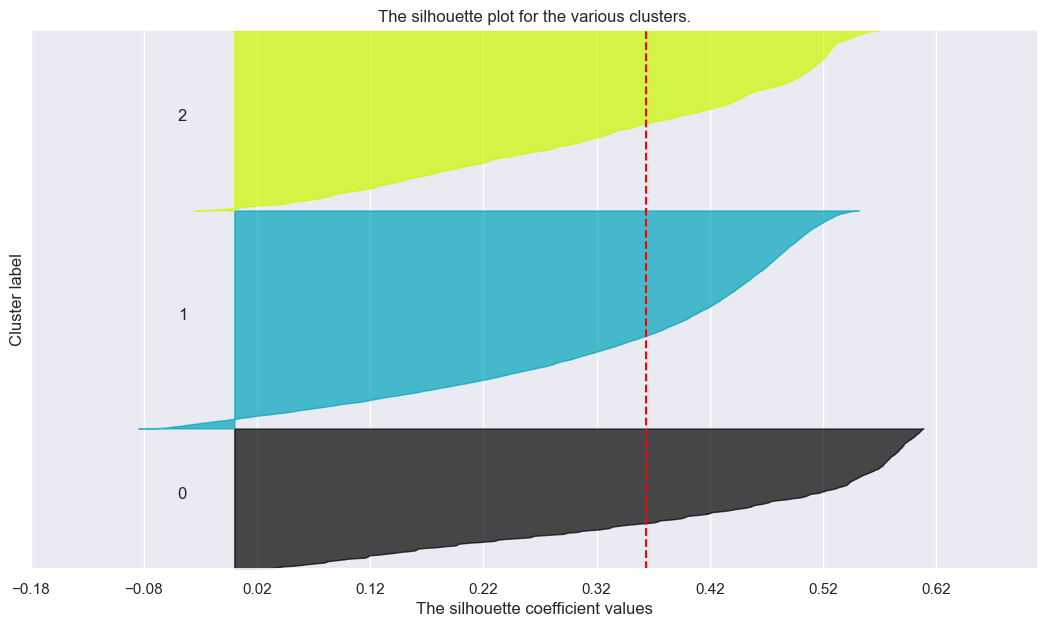

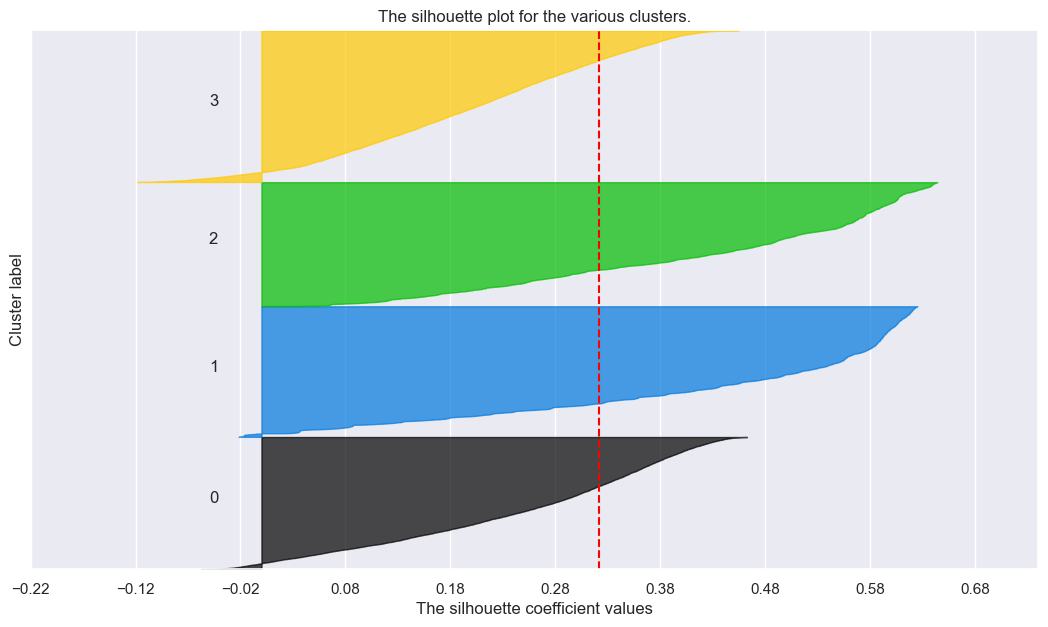

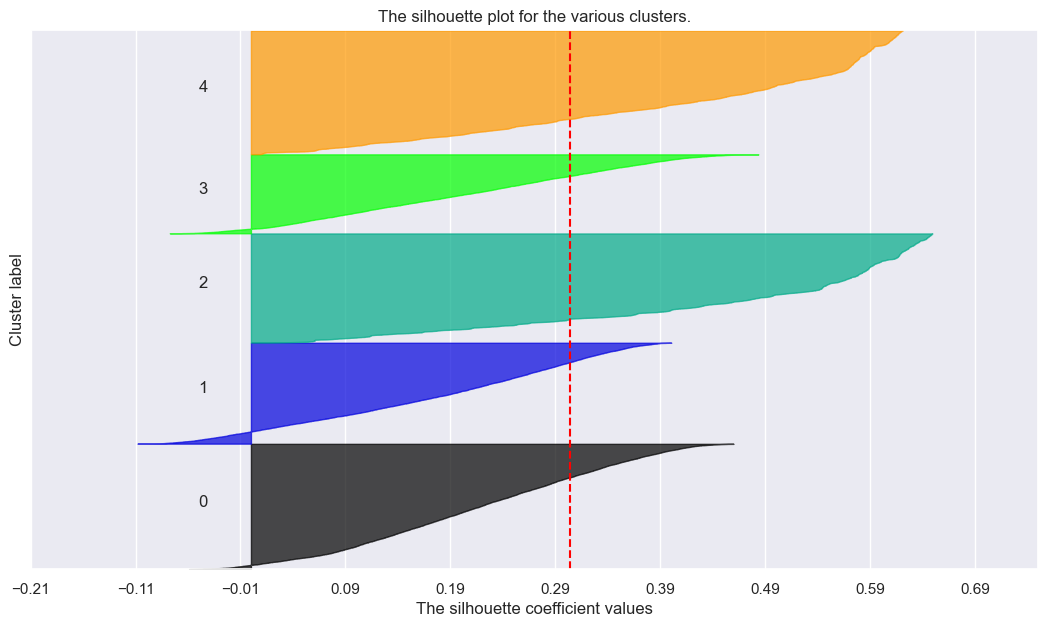

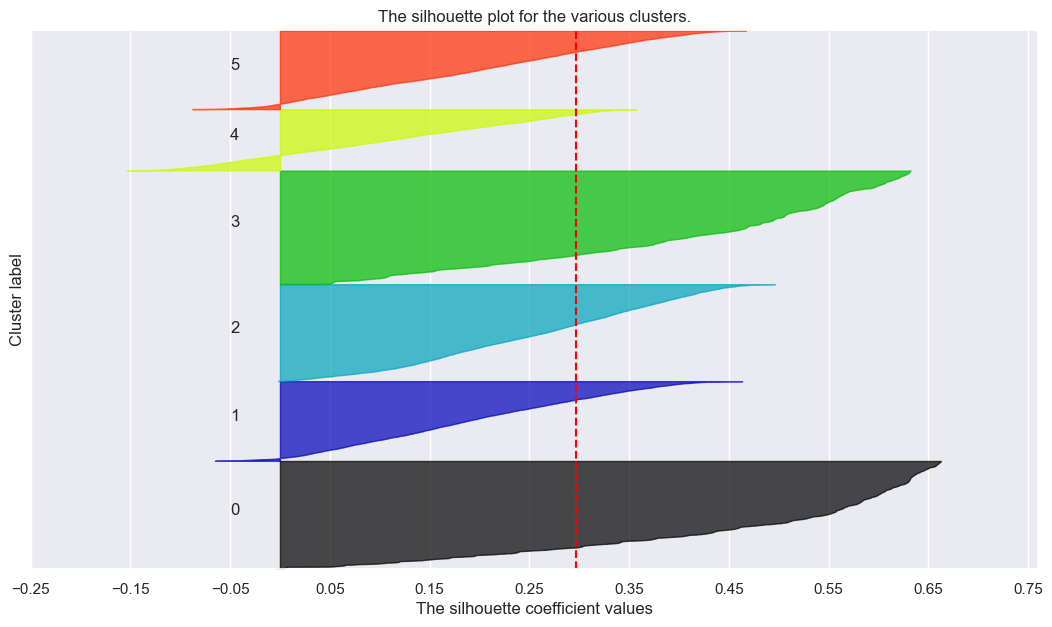

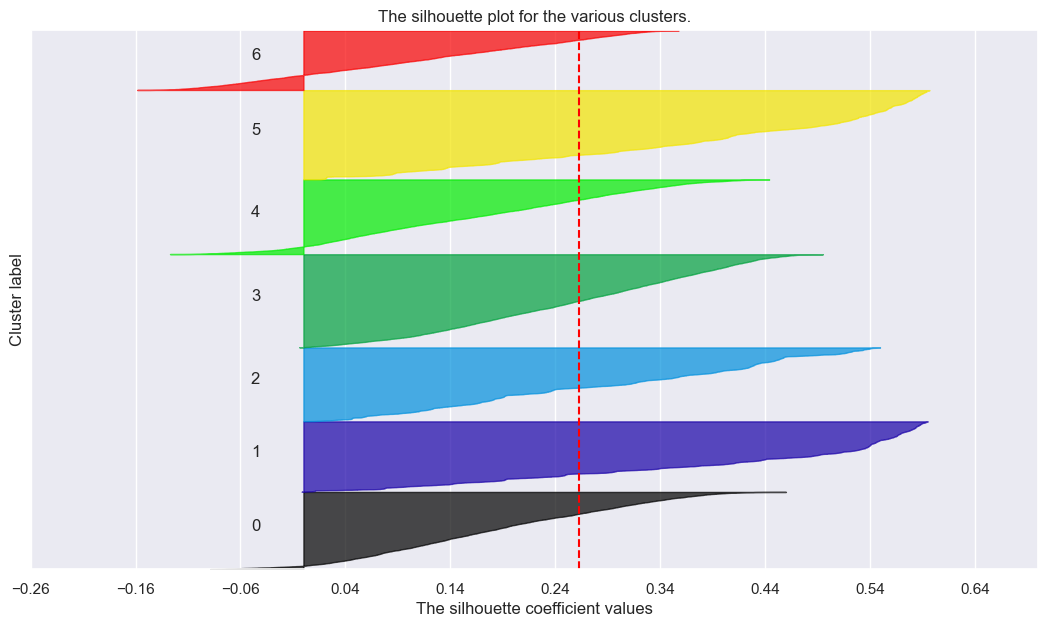

In [37]:
avg_silhouette = []
for nclus in range(2, 8):  # Loop from 2 to 7 clusters
    fig = plt.figure(figsize=(13, 7))
    
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_behaviour)

    silhouette_avg = silhouette_score(df_behaviour, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df_behaviour, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() - 0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(df_behaviour) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

plt.show()


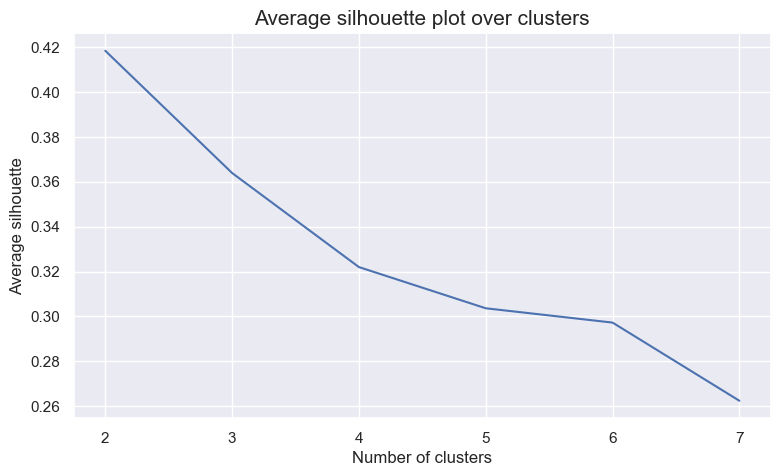

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(range(2, 8), avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.xticks(range(2, 8)) 
plt.show()

### 3.2.3. K-Means Optimal clusters
After the analysis of the sillouete score and the inertia plot we conclude that the optimal amount of clusters is 2.

In [138]:
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)

df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,monetary,product_count,days_as_customer,weekends,daysweek,last_order,diversification
labels,,,,,,,
0,0.058588,0.036956,0.100220,0.054153,0.074001,0.543820,0.046949
1,0.116803,0.128146,0.632695,0.135159,0.182918,0.849089,0.165368


In [139]:
r2 = get_r2(df_behaviour, km_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_2"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R² Score: 0.5039774408309959
Silhouette Score: 0.41840381746375466


<a class="anchor" id="som">

## 3.3. Self-Organizing Maps (SOM)
</a>
 Self-Organizing Map (SOM) is a type of neural network used for for dimensionality reduction and visualization of high-dimensional data. It maps high-dimensional data into a lower-dimensional (typically 2D) grid while preserving the topological structure of the data. This makes SOM useful for clustering, pattern recognition, and visualizing complex relationships in datasets.

In [41]:
data_som = df_behaviour.copy()

In [42]:
num_data_points = data_som.shape[0]
print("Nr. of data points:" , num_data_points)

print("Mapsize:" , 5*(num_data_points)**(1/2)) 

Nr. of data points: 28526
Mapsize: 844.4820898041592


In [43]:
def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]: 
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal  

def calculate_topographic_error(som, data):
    """Calculate topographic error for SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  
        distances = np.linalg.norm(som._weights - sample, axis=-1) 
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    return errors / len(data)


def evaluate_scaling_methods(data, scaling_methods, M=20, N=20, iterations=500):
    results = []
    for method_name, scaler in scaling_methods.items():
        scaled_data = scaler.fit_transform(data)
        
        som = MiniSom(M, N, scaled_data.shape[1], sigma=5.0, learning_rate=0.5, random_seed=42)
        som.random_weights_init(scaled_data)
        som.train(scaled_data, iterations)
        
        qe = som.quantization_error(scaled_data)
        te = calculate_topographic_error(som, scaled_data)
        
        results.append({"Scaling Method": method_name, "QE": qe, "TE": te})
    
    return pd.DataFrame(results)

scaling_methods = {"Min-Max Scaling": MinMaxScaler(), "Standardization": StandardScaler(), "Robust Scaling": RobustScaler()}

results = evaluate_scaling_methods(df_behaviour.values, scaling_methods)
print(results)

    Scaling Method        QE        TE
0  Min-Max Scaling  0.313752  0.131634
1  Standardization  1.609276  0.086553
2   Robust Scaling  1.273695  0.105728


The best scaler for us is MinMax Scaler so we are going to keep it.

### 3.3.1. Finding the best choice of parameters and training the SOM

Quantization Error and Topographic Error are two important metrics used to evaluate the performance of a Self-Organizing Map:

- **Quantization Error (QE)**:
    - Measures the average distance between each data point and its Best Matching Unit (BMU) on the SOM grid.
    - Lower QE is better: it means the SOM is better at clustering the data points close to their BMUs.
- **Topographic Error (TE)**:
    - Measures how well the SOM preserves the structure (topology) of the input data.
    - Lower TE is better: it means that the SOM maintains the topology of the original data (0 indicates excellent topographic representation and 1 is the maximum error).

In [44]:
def grid_search_som(data, param_grid):

    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    results = []
    for params in itertools.product(*param_grid.values()):
        grid_size, sigma, learning_rate, iterations = params
        som = MiniSom(
            x=grid_size[0], y=grid_size[1],
            input_len=data.shape[1],
            sigma=sigma, learning_rate=learning_rate,
            random_seed=42, neighborhood_function='gaussian')
        
        som.random_weights_init(data)
        som.train(data, iterations)

        qe = som.quantization_error(data)
        te = calculate_topographic_error(som, data)

        results.append({
            'Grid Size': grid_size,
            'Sigma': sigma,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Quantization Error': qe,
            'Topographic Error': te})

    return pd.DataFrame(results)

def get_neighbors_hexagonal(som, node):
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal

In [45]:
param_grid = {
    'grid_size': [(30, 30)],
    'sigma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0],
    'iterations': [500, 1000]}

In [46]:
grid_search = grid_search_som(df_behaviour, param_grid)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [47]:
grid_search['Combined Score'] = grid_search['Quantization Error'] + grid_search['Topographic Error']
best_row_idx = grid_search['Combined Score'].idxmin()
best_params = grid_search.loc[best_row_idx]
print("Best Parameters:")
print(best_params)

Best Parameters:
Grid Size             (30, 30)
Sigma                      3.0
Learning Rate              1.5
Iterations                 500
Quantization Error    0.302836
Topographic Error     0.246547
Combined Score        0.549383
Name: 56, dtype: object


In [48]:
grid_search.sort_values(by='Combined Score', ascending=True).head()

,Grid Size,Sigma,Learning Rate,Iterations,Quantization Error,Topographic Error,Combined Score
56,"(30, 30)",3.0,1.5,500,0.302836,0.246547,0.549383
55,"(30, 30)",3.0,1.0,1000,0.281447,0.381967,0.663415
54,"(30, 30)",3.0,1.0,500,0.223758,0.450677,0.674434
57,"(30, 30)",3.0,1.5,1000,0.277228,0.399881,0.677109
48,"(30, 30)",2.5,2.0,500,0.197725,0.495583,0.693308


#### 3.3.1.1. Training SOM on the best parameters

In [76]:
best_grid_size = (30, 30)
best_sigma = 3.0
best_learning_rate = 1.5
best_iterations = 500

som = MiniSom(
    x=best_grid_size[0], 
    y=best_grid_size[1], 
    input_len=df_behaviour.shape[1],
    sigma=best_sigma, 
    learning_rate=best_learning_rate,
    neighborhood_function='gaussian',
    random_seed=42)

df_behaviour_np = df_behaviour.to_numpy()

som.pca_weights_init(df_behaviour_np)

print("PCA weights init")
print("Before training:")
qe_before = np.round(som.quantization_error(df_behaviour_np), 5)
te_before = np.round(calculate_topographic_error(som, df_behaviour_np), 5)
print(f"QE: {qe_before}, TE: {te_before}")

som.train(df_behaviour_np, best_iterations)

print("After training:")
qe_after = np.round(som.quantization_error(df_behaviour_np), 5)
te_after = np.round(calculate_topographic_error(som, df_behaviour_np), 5)
print(f"QE: {qe_after}, TE: {te_after}")


# som = MiniSom(
#     x=best_grid_size[0], 
#     y=best_grid_size[1], 
#     input_len=df_behaviour.shape[1],
#     sigma=best_sigma, 
#     learning_rate=best_learning_rate,
#     neighborhood_function='gaussian',
#     random_seed=42
# )

# som.random_weights_init(df_behaviour_np)

# print("Random weights init")
# print("Before training:")
# qe_before = np.round(som.quantization_error(df_behaviour_np), 5)
# te_before = np.round(calculate_topographic_error(som, df_behaviour_np), 5)
# print(f"QE: {qe_before}, TE: {te_before}")

# som.train(df_behaviour_np, best_iterations)

# print("After training:")
# qe_after = np.round(som.quantization_error(df_behaviour_np), 5)
# te_after = np.round(calculate_topographic_error(som, df_behaviour_np), 5)
# print(f"QE: {qe_after}, TE: {te_after}")

PCA weights init
Before training:
QE: 0.76177, TE: 0.0
After training:
QE: 0.2536, TE: 0.5725


- Regarding QE, the average distance between data points and their BMU decreased significantly (SOM has learned to better represent the data).
- TE has increased, meaning that approximately 57% of the data points now have BMUs and second BMUs that are not adjacent on the SOM grid. <br>
This suggest that while SOM has improved in representing the data, it has become less efective at preserving the topological structure of the input data. However, these results with the PCA weights initialization are better than with random weights initialization.

In [50]:
def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2) 
    y = j * (np.sqrt(3) / 2)
    return x, y

def plot_hexagons(ax, colornorm, matrix_vals, label="", annot=False, cmap=None):
    """
    Plots the values in 'matrix_vals' using hexagonal cells.
    
    Parameters:
    -----------
    ax : matplotlib Axes
        The axes on which to draw the hexagons.
    colornorm : matplotlib.colors.Normalize
        Normalization object for mapping values to [0, 1].
    matrix_vals : 2D array
        Values to be visualized. shape = (M, N).
    label : str, optional
        Title label for the subplot.
    annot : bool, optional
        If True, numeric values are shown inside each hex.
    cmap : matplotlib.colors.Colormap or None, optional
        Colormap to use. Defaults to 'inferno' if None is provided.
    """
    if cmap is None:
        cmap = cm.coolwarm

    rows, cols = matrix_vals.shape
    for i in range(rows):
        for j in range(cols):
            x, y = convert_map_to_euclidean(i, j)
            value = matrix_vals[i, j]
            hex_color = cmap(colornorm(value))
            hex_patch = RegularPolygon((x, y), numVertices=6, radius=np.sqrt(1 / 3), facecolor=hex_color, alpha=1, edgecolor="white", linewidth=0.5)
            ax.add_patch(hex_patch)

            if annot:
                annot_val = int(np.round(value))
                ax.text(x, y, annot_val, ha="center", va="center", fontsize="x-small",)

    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=colornorm, cmap=cmap)
    sm.set_array([])
    Colorbar(ax=cax, mappable=sm, orientation="vertical")

### 3.3.2. Visualizing Component Planes of the SOM for Feature Analysis

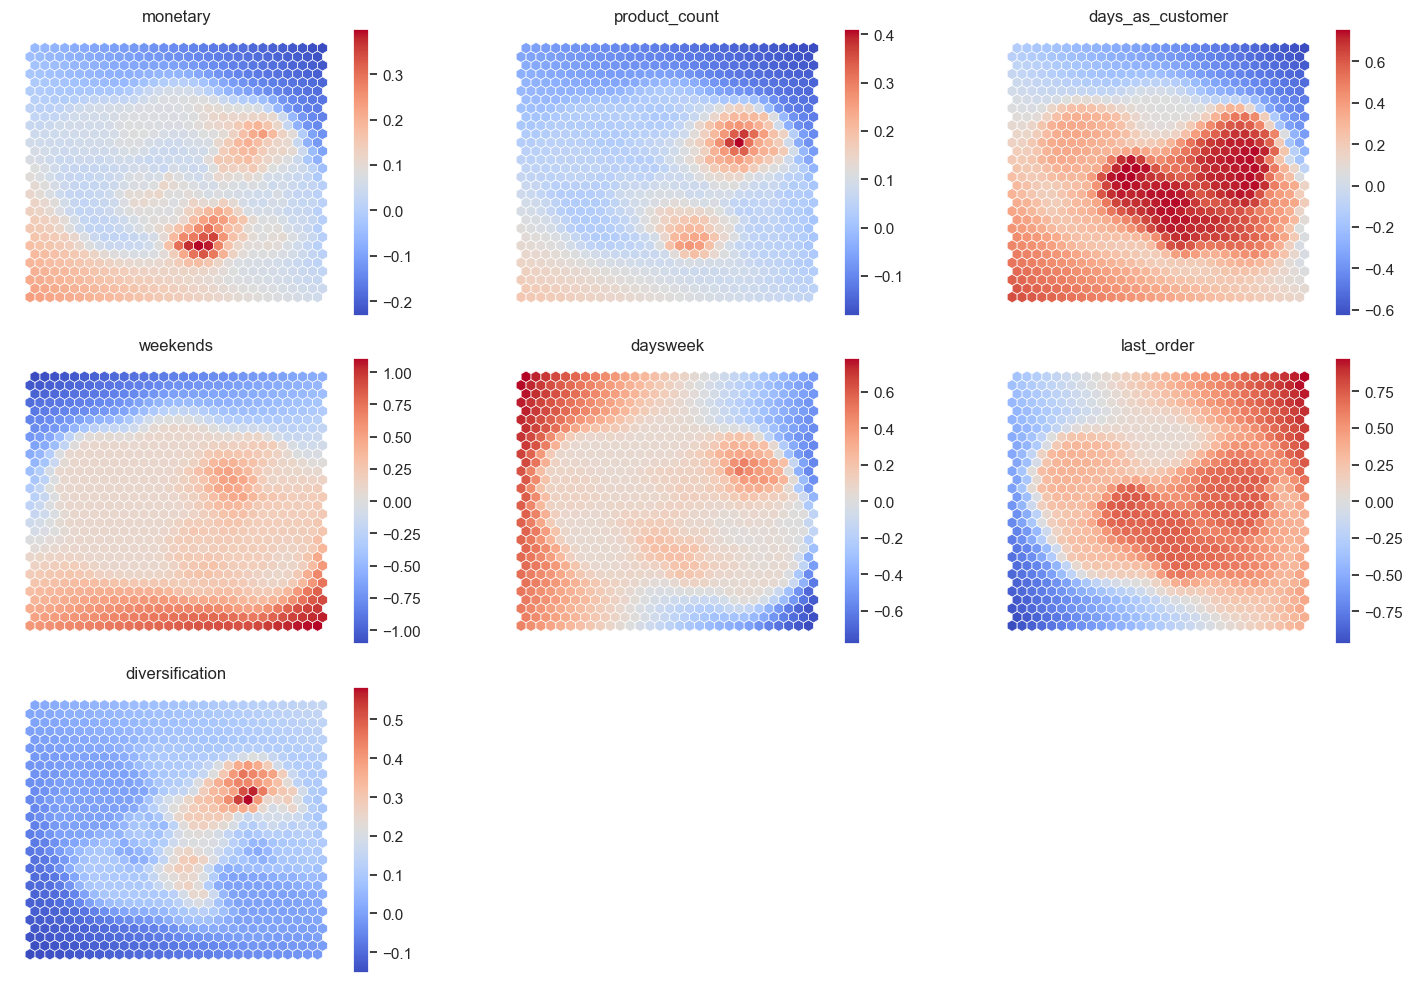

In [75]:
weights = som.get_weights()  
num_features = weights.shape[2]
feature_names = df_behaviour.columns

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  
axes = axes.flatten() 

for i in range(min(num_features, rows * cols)):
    plane = weights[:, :, i]  
    ax = axes[i]

    colornorm = Normalize(vmin=plane.min(), vmax=plane.max())
    
    plot_hexagons(ax=ax, colornorm=colornorm, matrix_vals=plane, label=feature_names[i], annot=False)

for j in range(min(num_features, rows * cols), rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- Areas with low or no activity (blue regions) might represent less common customer behaviors.

- In the monetary component plane, the hexagons with higher intensity (representing higher spending) correspond to similar regions with higher values in the product_count component plane.This indicates the correlation between spending more money and buying more products.

### 3.3.3. Determining the optimal number of clusters for SOM using K-Means

We start by flattening the weights so we can work with the SOM grid as a 2D dataset and apply to K-Means Clustering.

In [52]:
weights_3d = som.get_weights()         
M, N, num_features = weights_3d.shape

weights_2d = weights_3d.reshape(M * N, num_features)

Optimal number of clusters (k): 6
Silhouette Score for k=6: 0.479


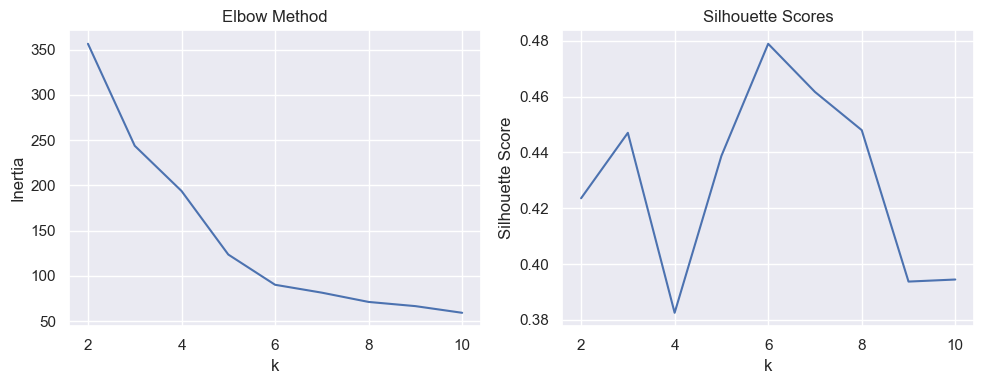

In [53]:
inertias = []
sil_scores = []
K_values = range(2, 11)

best_silhouette_score = -1
best_k = None

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(weights_2d)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(weights_2d, labels)
    sil_scores.append(sil)
    if sil > best_silhouette_score:
        best_silhouette_score = sil
        best_k = k

print(f"Optimal number of clusters (k): {best_k}")
print(f"Silhouette Score for k={best_k}: {best_silhouette_score:.3f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_values, inertias)
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_values, sil_scores)
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

With the both graphs we can see that the optimal number of clusters is 6. We are going to analyse other methods to confirm the final number of clusters.

### 3.3.3. U-Matrix using the trained SOM

The U-Matrix (Unified Distance Matrix) is a visualization used to represent the distances between neurons and highlights the boundaries between different clusters of data points. 
- Darker regions in the U-Matrix represent large distances (indicating boundaries between clusters)
- Lighter regions indicate small distances (showing areas of similarity)

#### Ploting the U-Matrix using the trained SOM

In [80]:
u_matrix = som.distance_map()  

In [81]:
M, N = som.get_weights().shape[:2] 
final_weights = som.get_weights().reshape(M*N, -1)  

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(final_weights)

In [82]:
cluster_coords = defaultdict(list)

for i in range(M):
    for j in range(N):
        neuron_index = i*N + j
        cluster_id = labels[neuron_index]
        x, y = convert_map_to_euclidean(i, j)
        cluster_coords[cluster_id].append((x, y))

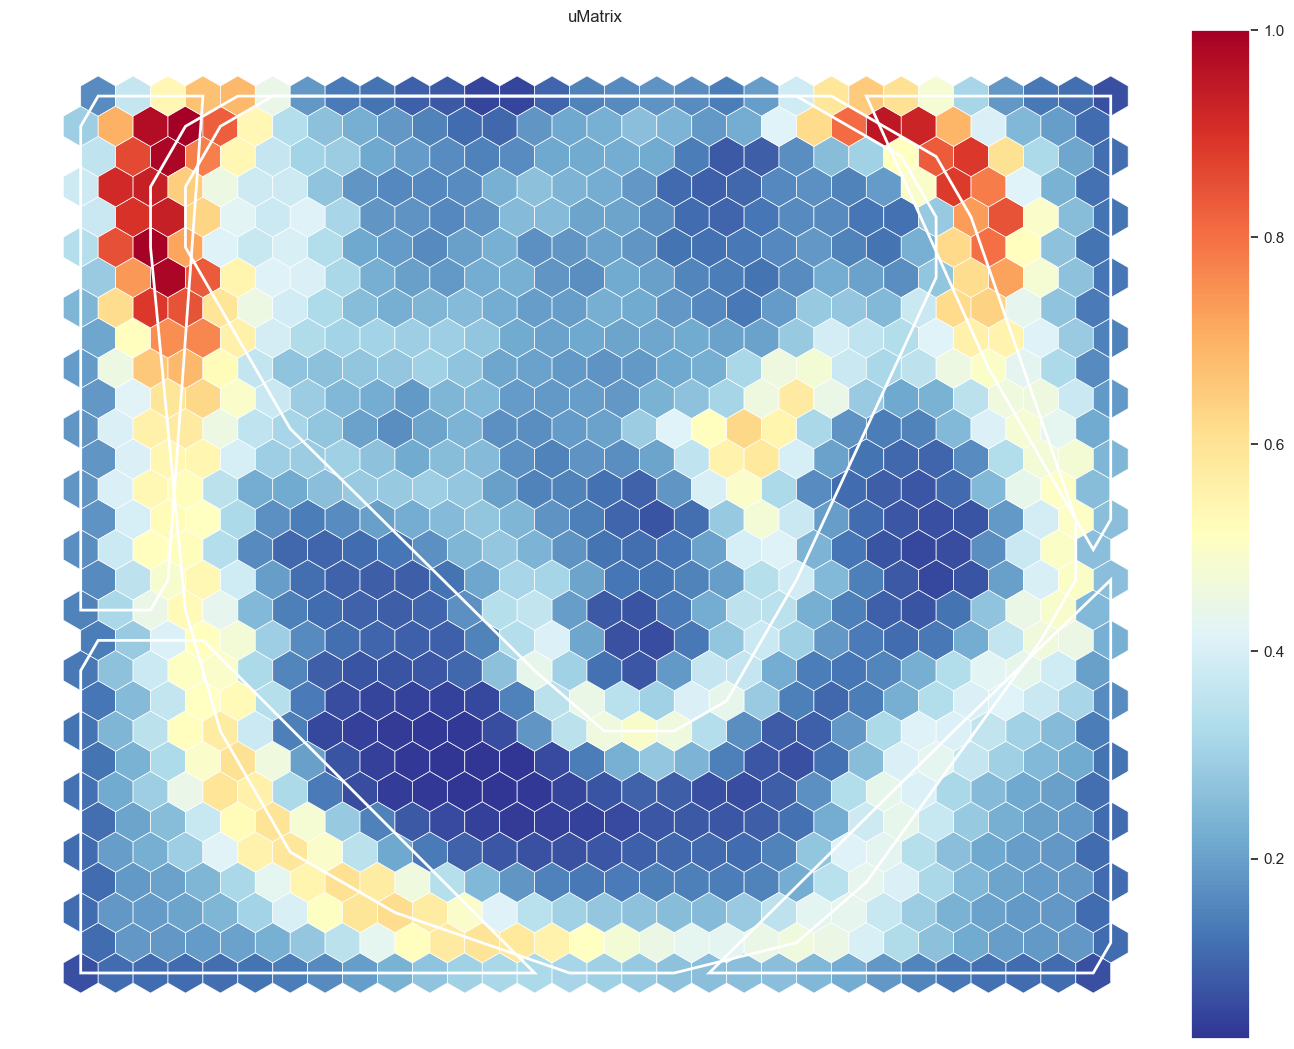

In [83]:
fig, ax = plt.subplots(figsize=(16, 16))

colornorm = Normalize(vmin=u_matrix.min(), vmax=u_matrix.max())

plot_hexagons(ax, colornorm, u_matrix, label="uMatrix", annot=False, cmap=cm.RdYlBu_r)

for cluster_id, coords in cluster_coords.items():
    if not coords:
        continue

    if len(coords) < 3:
        x_c, y_c = np.mean([x for x, _ in coords]), np.mean([y for _, y in coords])
        circ = plt.Circle((x_c, y_c), radius=0.3, fill=False, color='red', linewidth=2)
        ax.add_patch(circ)
        continue

    points = MultiPoint([Point(x, y) for (x, y) in coords])
    hull = points.convex_hull  

    if hull.geom_type == 'Polygon':
        hull_x, hull_y = hull.exterior.xy
        hull_coords = np.vstack((hull_x, hull_y)).T 
        
        poly = Polygon(
            hull_coords,
            fill=False,
            edgecolor='white',
            linewidth=2
        )
        ax.add_patch(poly)
    elif hull.geom_type == 'LineString':
        lx, ly = hull.xy
        ax.plot(lx, ly, color='red', linewidth=2)

plt.show()

The yellow and orange regions represent areas where there is a significant difference (distance) between neighboring neurons, indicating distinct clusters of behaviours. <br>
The blue areas represent regions where there is minimal difference between the neurons, representing a homogeneous behaviour within that cluster.

### 3.3.4. Hits Map


The Hit Map visualizes the number of times a neuron is the Best Matching Unit for a given input data point. This allows us to see which neurons are more active in representing the data and which ones are less active.

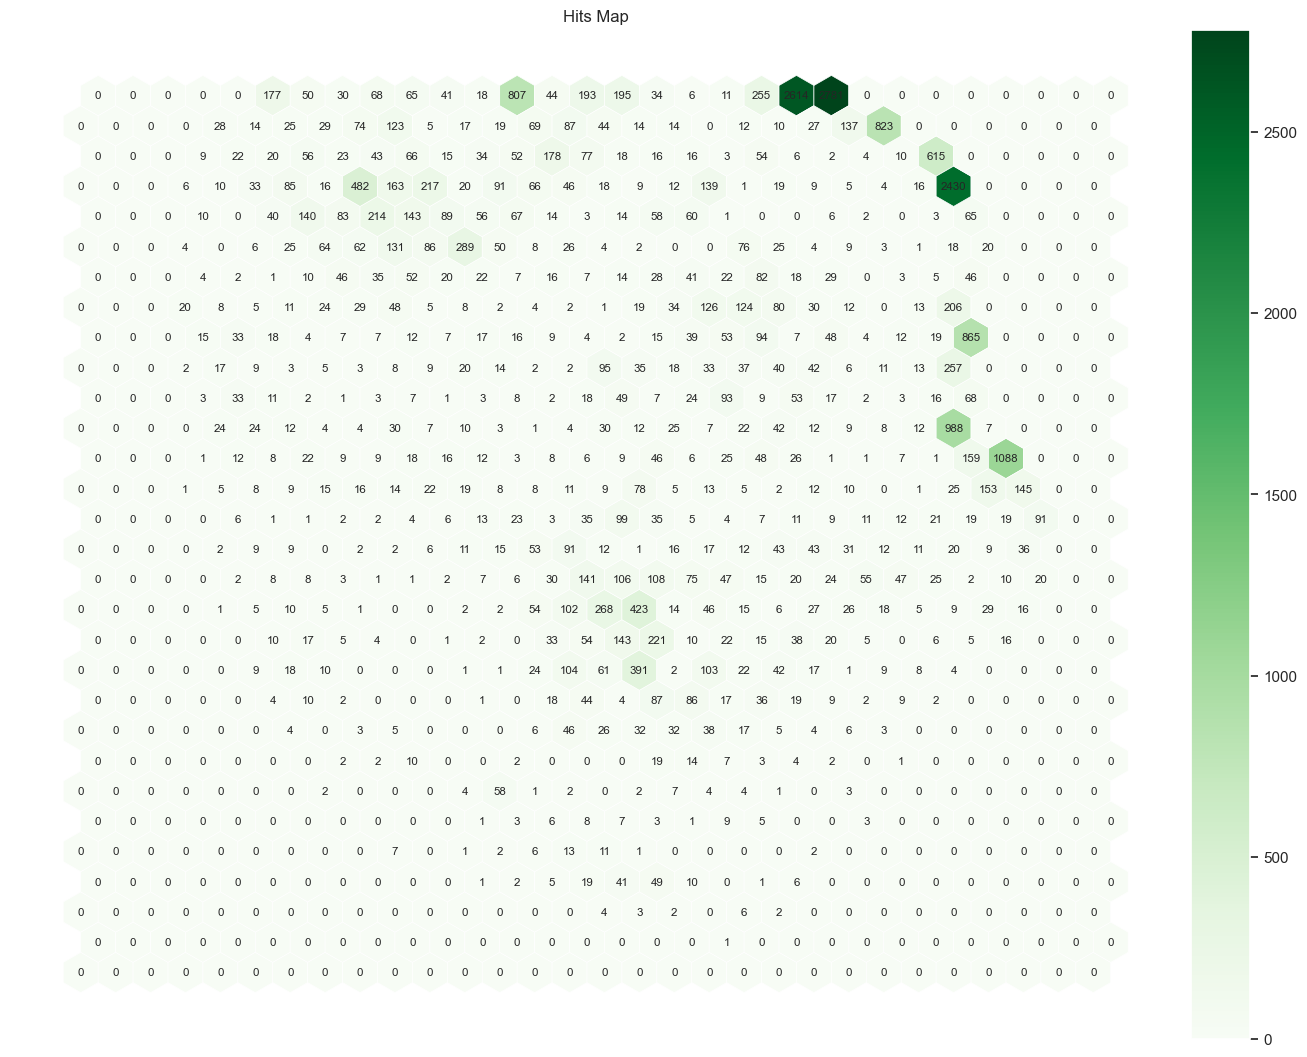

In [84]:
def plot_hits_map_hex(som, data, title="Hits Map"):
    M, N = som.get_weights().shape[:2]
    hits_map = np.zeros((M, N))
    
    for _, sample in data.iterrows():
        sample = sample.values
        i, j = som.winner(sample)
        hits_map[i, j] += 1
    
    colornorm = Normalize(vmin=0, vmax=hits_map.max())
    fig, ax = plt.subplots(figsize=(16, 16))
    plot_hexagons(ax=ax, colornorm=colornorm, matrix_vals=hits_map, label=title, annot=True, cmap=cm.Greens)
    plt.show()

plot_hits_map_hex(som, df_behaviour)

High-Density Regions: The neurons in the top right have a very high number of hits compared to the rest of the map. This indicates a concentrated cluster of data points, meaning many similar data samples are grouped in this area.

Sparse Regions: The neurons in the corners have very few or no hits (zeros). These areas indicate neurons that represent no data points.

### 3.3.6. K-Means on top of SOM units

KMeans clustering is applied on the trained SOM’s weights. This combines the spatial organization of SOM with the clustering of KMeans.

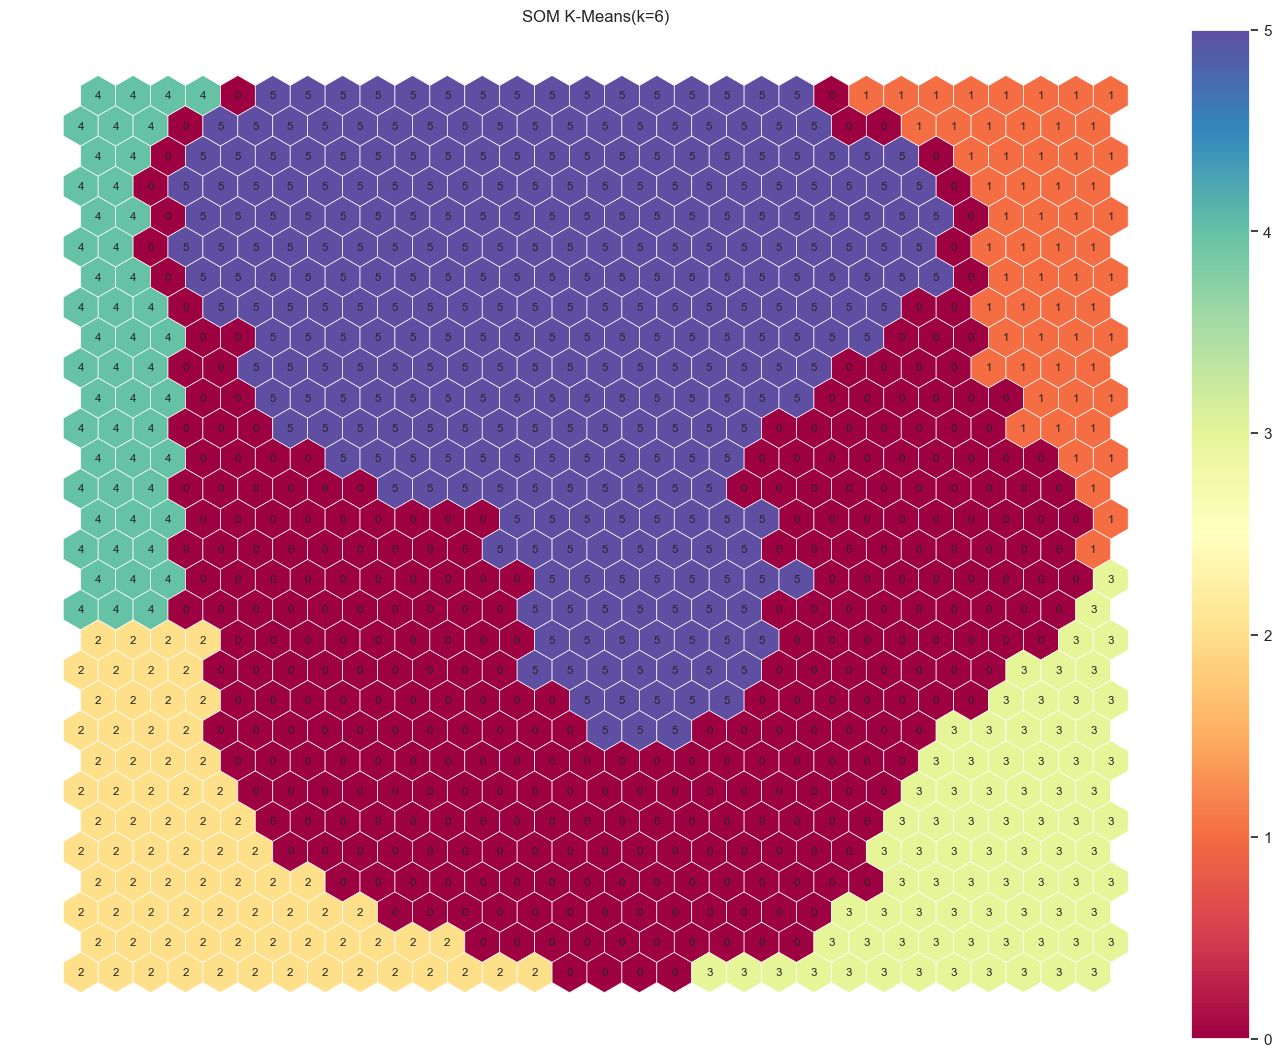

In [124]:
weights_3d = som.get_weights() 
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M*N, num_features)

k=6
kmeans_behaviour = KMeans(n_clusters=k, init='k-means++', random_state=42)
nodeclus_labels_behaviour = kmeans_behaviour.fit_predict(weights_2d)

cluster_map = labels.reshape(M, N)

fig, ax = plt.subplots(figsize=(16, 16))

norm = colors.Normalize(vmin=0, vmax=k-1)

plot_hexagons(ax=ax, colornorm=norm, matrix_vals=cluster_map, label=f"SOM K-Means(k={k})", annot=True, cmap=cm.Spectral)
plt.show()

### 3.3.7. Hierarchical Clustering on top of SOM units

Hierarchical Clustering techniques (e.g., Agglomerative Clustering) are applied to the SOM’s weights, allowing for a hierarchical structure of clusters.

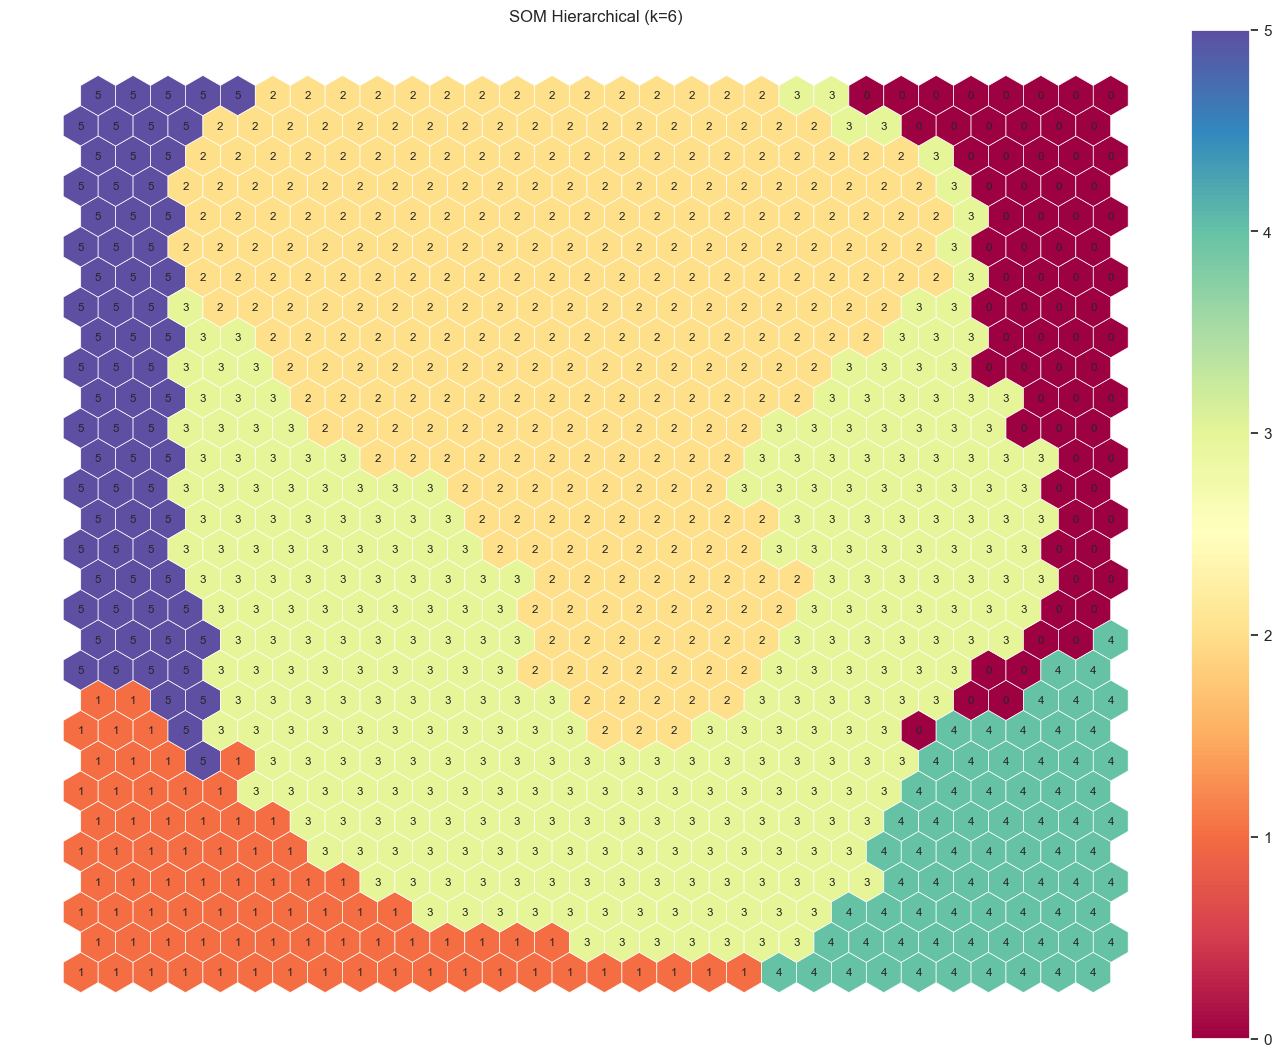

In [88]:
weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

k = 6
hc = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')

hc_labels = hc.fit_predict(weights_2d)

cluster_map = hc_labels.reshape(M, N)

fig, ax = plt.subplots(figsize=(16, 16))
norm = plt.Normalize(vmin=0, vmax=k-1)

plot_hexagons(ax=ax, colornorm=norm, matrix_vals=cluster_map, label=f"SOM Hierarchical (k={k})", annot=True, cmap=plt.cm.Spectral)
plt.show()

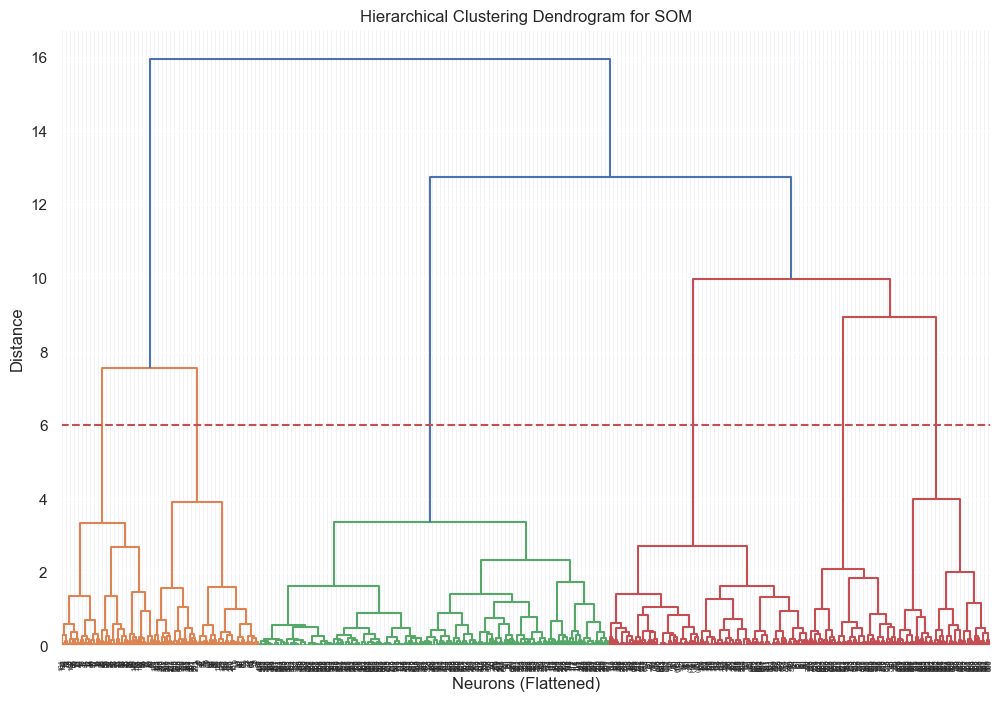

In [90]:
from scipy.cluster.hierarchy import linkage

weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

linkage_matrix = linkage(weights_2d, method='ward', metric='euclidean')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.axhline(y=6, color='r', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram for SOM')
plt.xlabel('Neurons (Flattened)')
plt.ylabel('Distance')
plt.show()

### 3.3.8. Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index for different approaches of clustering 

#### SOM with KMeans

In [140]:
# SOM with KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

sil_kmeans = silhouette_score(weights_2d, kmeans_labels, metric='euclidean')
dbi_kmeans = davies_bouldin_score(weights_2d, kmeans_labels)
ch_kmeans = calinski_harabasz_score(weights_2d, kmeans_labels)

r2 = get_r2(weights_df, kmeans_labels)

print("SOM + KMeans Clustering:")
print(f"Silhouette Score: {sil_kmeans:.3f}")
print(f"Davies-Bouldin Index: {dbi_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {ch_kmeans:.3f}")
print(f"R^2 Score: {r2:.3f}")

new_row_kmeans = pd.DataFrame({"Silhouette_Score": [sil_kmeans], "R2": [r2]}, index=["SOM_KMeans_6"])
results_df = pd.concat([results_df, new_row_kmeans], axis=0, ignore_index=False)

SOM + KMeans Clustering:
Silhouette Score: 0.509
Davies-Bouldin Index: 0.658
Calinski-Harabasz Index: 880.567
R^2 Score: 0.831


1. Silhouette Score (0.509):
- The Silhouette Score measures how well-separated and cohesive the clusters are.
- The score indicates good clustering quality. Some clusters are clear but there is still overlap or points that could belong to multiple clusters.

2. Davies-Bouldin Index (0.658):
- The Davies-Bouldin Index (DBI) measures the compactness and separation of clusters.
- A DBI of 0.658 indicates that the clusters are compact and well-separated. Lower DBI values (<1) suggest good clustering performance. 

3. Calinski-Harabasz Index (880.567):
- The Calinski-Harabasz Index (CH) measures the variance between and within clusters.
- The score indicates well-defined, compact clusters with significant separation between them.

#### SOM with Hierachical Clustering

In [141]:
# SOM with Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=6, linkage='ward', metric='euclidean')
hc_labels = hc.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

sil_hc = silhouette_score(weights_2d, hc_labels, metric='euclidean')
dbi_hc = davies_bouldin_score(weights_2d, hc_labels)
ch_hc = calinski_harabasz_score(weights_2d, hc_labels)

r2 = get_r2(weights_df, hc_labels)

print("\nSOM with Hierarchical Clustering:")
print(f"Silhouette Score: {sil_hc:.3f}")
print(f"Davies-Bouldin Index: {dbi_hc:.3f}")
print(f"Calinski-Harabasz Index: {ch_hc:.3f}")
print(f"R^2 Score: {r2:.3f}")

new_row_hc = pd.DataFrame({"Silhouette_Score": [sil_hc], "R2": [r2]}, index=["SOM_Hierarchical_6"])
results_df = pd.concat([results_df, new_row_hc], axis=0, ignore_index=False)


SOM with Hierarchical Clustering:
Silhouette Score: 0.485
Davies-Bouldin Index: 0.744
Calinski-Harabasz Index: 759.748
R^2 Score: 0.809


1. Silhouette Score (0.485):
- The score is slightly higher for SOM with KMeans, indicating that KMeans creates better-separated clusters with slightly less overlap compared to HC.

2. Davies-Bouldin Index (0.744):
- The lower index for SOM with KMeans shows that its clusters are more compact and better separated than those generated by SOM with HC.

3. Calinski-Harabasz Index (759.748):
- The index is higher for SOM with KMeans, indicating that its clusters exhibit better-defined inter-cluster and intra-cluster variance compared to SOM with HC.

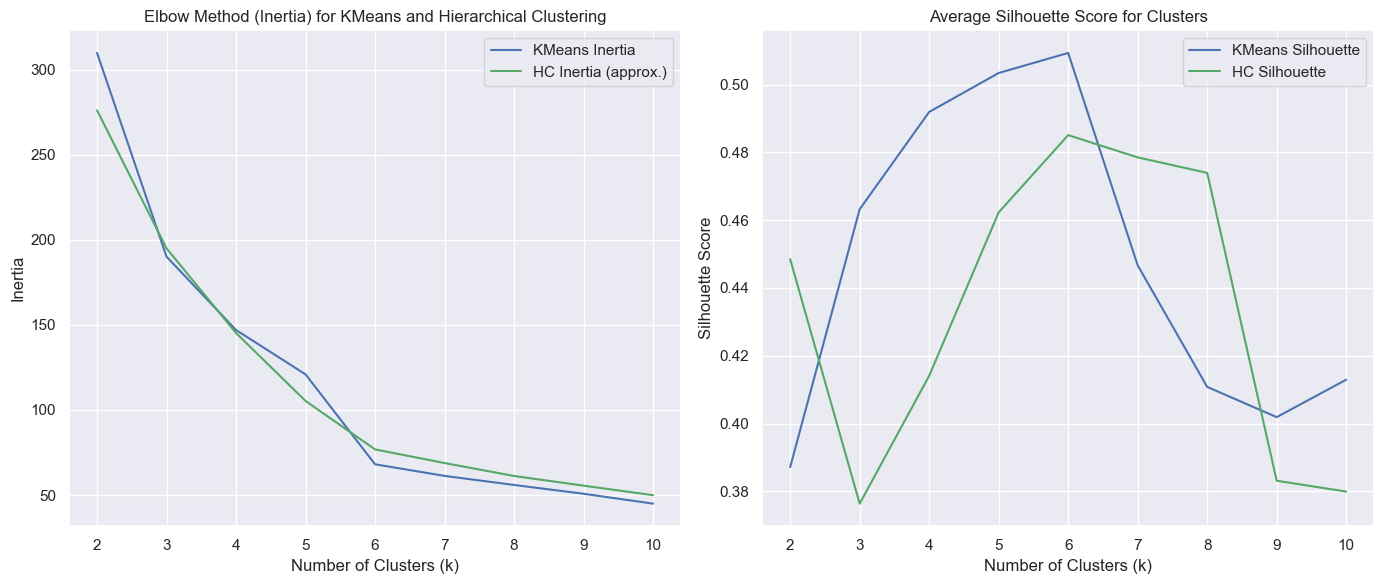

In [93]:
weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

k_range = range(2, 11)
inertia_hc = [] 
inertia_kmeans = []
silhouette_kmeans = []
silhouette_hc = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(weights_2d)
    
    inertia_kmeans.append(kmeans.inertia_)
    silhouette_kmeans.append(silhouette_score(weights_2d, kmeans_labels, metric='euclidean'))

for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hc_labels = hc.fit_predict(weights_2d)
    
    inertia_sum = 0
    for cluster in range(k):
        cluster_points = weights_2d[hc_labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        inertia_sum += np.sum((cluster_points - cluster_center) ** 2)
    inertia_hc.append(inertia_sum)
    
    silhouette_hc.append(silhouette_score(weights_2d, hc_labels, metric='euclidean'))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_kmeans, color='b', label="KMeans Inertia")
plt.plot(k_range, inertia_hc, color='g', label="HC Inertia (approx.)")
plt.title("Elbow Method (Inertia) for KMeans and Hierarchical Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_kmeans, color='b', label="KMeans Silhouette")
plt.plot(k_range, silhouette_hc, color='g', label="HC Silhouette")
plt.title("Average Silhouette Score for Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.tight_layout()
plt.show()


### 3.3.9 SOM Clustering - Final Solution 

In [101]:
# SOM with KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

#### Flattened Weights + DataFrame

In [95]:
# nodes_behaviour = weights_2d

# df_nodes_behaviour = pd.DataFrame(nodes_behaviour, columns=data_som.columns)
# df_nodes_behaviour['label'] = nodeclus_labels_behaviour
# df_nodes_behaviour

# # df_nodes_behaviours = pd.DataFrame(nodes_behaviour, columns=df_behaviour.columns)
# # df_nodes_behaviours['label'] = nodeclus_labels
# # df_nodes_behaviours

#### KMeans Labels for 3 Clusters and BMU Indices per Data Row

In [96]:
# kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
# kmeans_labels = kmeans.fit_predict(weights_2d)

# bmu_index_behaviour = [som.winner(sample) for sample in df_behaviour.values]
# bmu_index_behaviour

#### Reshape KMeans Labels into a 2D Map and Final Labels per Data Row


In [97]:
# hier_map = kmeans_labels.reshape(M, N)  
# som_final_labels_preferences = [hier_map[i, j] for (i, j) in bmu_index_behaviour]
# print(som_final_labels_preferences)

#### Combine with Original df_behaviour

In [98]:
# df_final_behaviour = pd.concat([df_behaviour, pd.Series(som_final_labels_preferences, name='label', index=df_behaviour.index)], axis=1)
# df_final_behaviour

#### Group and Aggregate

In [99]:
# df_final_behaviour[df_behaviour.columns.tolist()+['label']].groupby('label').mean()

<a class="anchor" id="mean">
    
## 3.4. Mean Shift Clustering
</a>

### 3.4.1. MSC - Defining the bandwith
Bandwidth is the window size used for the kernel density estimation.
This code estimates the optimal bandwidth to be used in Mean Shift clustering by considering the 40% closest points in the dataset, this will help understand around which values we should try the bandwidth around (a higher quantile means that we will have more points in the same clustering.

In [102]:
bandwidth = estimate_bandwidth(df_behaviour, quantile=0.4, random_state=1, n_jobs=-1)
bandwidth

0.49818176660546803

In [105]:
bandwidths = np.arange(0.3, 0.5, 0.025) 
results = []

for bw in bandwidths:
    ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=4)
    ms_labels = ms.fit_predict(df_behaviour)
    num_clusters = len(np.unique(ms_labels))

    df_behaviour_with_labels = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
    
    sil_score = silhouette_score(df_behaviour, ms_labels)
    
    r2_mean = get_r2(df_behaviour, ms_labels)
    
    results.append((bw, num_clusters, sil_score, r2_mean))
    
    print(f"Bandwidth: {bw:.3f}, Number of Clusters: {num_clusters}, Silhouette Score: {sil_score:.3f}, R²: {r2_mean:.4f}")

Bandwidth: 0.300, Number of Clusters: 6, Silhouette Score: 0.321, R²: 0.6458
Bandwidth: 0.325, Number of Clusters: 5, Silhouette Score: 0.352, R²: 0.5056
Bandwidth: 0.350, Number of Clusters: 5, Silhouette Score: 0.352, R²: 0.5073
Bandwidth: 0.375, Number of Clusters: 5, Silhouette Score: 0.354, R²: 0.5104
Bandwidth: 0.400, Number of Clusters: 3, Silhouette Score: 0.330, R²: 0.0217
Bandwidth: 0.425, Number of Clusters: 3, Silhouette Score: 0.338, R²: 0.0190
Bandwidth: 0.450, Number of Clusters: 3, Silhouette Score: 0.345, R²: 0.0170
Bandwidth: 0.475, Number of Clusters: 3, Silhouette Score: 0.353, R²: 0.0155


### 3.4.2. MSC - Optimal amount of clusters
From the previous code, we conclude the best bandwith would be 0.375 because it has the best equilibrium between silhouete score and R². So we apply this to the following code.

In [142]:
ms = MeanShift(bandwidth=0.375, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_behaviour)

In [143]:
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(ms_labels, index=df_behaviour.index, name="ms_labels")], axis=1)

df_concat = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('labels').mean()
df_grouped

,monetary,product_count,days_as_customer,weekends,daysweek,last_order,diversification
labels,,,,,,,
0,0.058195,0.035687,0.087823,0.052574,0.072465,0.547942,0.044605
1,0.114191,0.123106,0.624008,0.131603,0.176844,0.832517,0.158494
2,0.642464,0.578947,0.885185,0.383333,0.638889,0.946296,0.250000
3,0.385521,1.000000,0.800000,0.800000,1.000000,0.833333,0.600000
4,0.163479,0.341796,0.794771,0.297059,0.449673,0.898497,0.555294


In [144]:
r2 = get_r2(df_behaviour, ms_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, ms_labels)
print(f"Silhouette Score: {silhouete}")

mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Mean-Shift_4"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R² Score: 0.5103561885832295
Silhouette Score: 0.3536708644059935


<a class="anchor" id="dbscan">
    
## 3.5. DBSCAN
</a>

### 3.5.1. DBSCAN - determine the eps
To understand the best eps value for our DBSCAN, we do a K-Distance graph:
- The **K-Distance graph** shows how the distance to the 20th nearest neighbor changes for each point.
- On the left, the distances are small, meaning points are close and form dense clusters.
- To the right, the distances increase, indicating points are becoming more spread out and sparse.
- The **"elbow"** is where the graph's slope increases sharply — this marks the transition from dense clusters to sparse points.

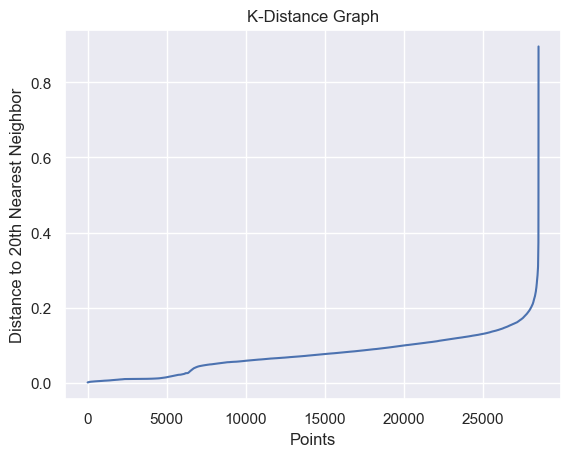

In [109]:
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_behaviour)

distances, _ = neigh.kneighbors(df_behaviour)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 20th Nearest Neighbor')
plt.title('K-Distance Graph')
plt.grid(True) 
plt.show()


### 3.5.2. DBSCAN - optimal number
From the previous graph we are able to conclude that the ideal **`eps`** is around 0.2 eps, so we choose 0.2 for this variable.

In [112]:
dbscan = DBSCAN(eps=0.2, min_samples=30, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_behaviour)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


This clustering won't be used nor analysed further because:
- Too computationaly expensive
- The results are not the best (forms 2 clusterings, one of noise and the other one of not noise)
- Its biggest strenght is being used in the removal of outliers.

<a class="anchor" id="gmm">
    
## 3.6. Gaussian Mixture
</a>

### 3.6.1. GMM - Determining number of clusters
For this we will use a plot that determines the optimal number of components (`n_components`) for a Gaussian Mixture Model (GMM) by comparing the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
  - **X-axis**: Represents the number of components in the GMM, ranging from 1 to 15.  
  - **Y-axis**: Shows the AIC and BIC scores. Lower values on the y-axis indicate better models based on the respective criteria.  

- **AIC (Akaike Information Criterion)**:  
  - Measures the goodness of fit while penalizing for model complexity.  
  - Lower AIC values signify a better balance between model complexity and fit.

- **BIC (Bayesian Information Criterion)**:  
  - Similar to AIC but applies a stronger penalty for complexity, favoring simpler models.  
  - Lower BIC values indicate the preferred model under this criterion.

- **Elbow Point in the Curve**: at **7 components**, because it's where the curve starts to flatten, suggesting that adding more components beyond this range provides diminishing improvements in model fit.

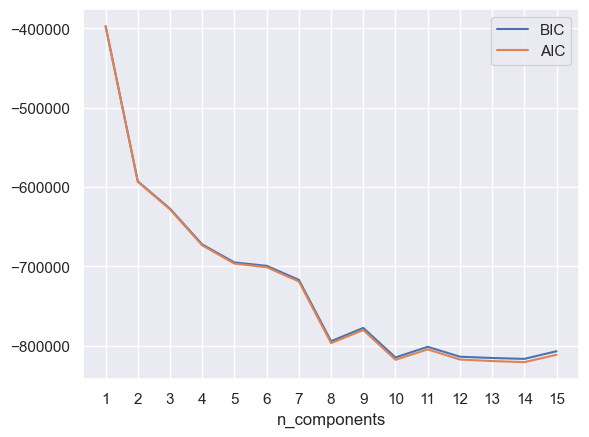

In [113]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_behaviour)
          for n in n_components]

bic_values = [m.bic(df_behaviour) for m in models]
aic_values = [m.aic(df_behaviour) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

### 3.6.2 GMM - Optimal number of clusters
As previously seen the optimal number of clusters for this algorithm is 3, this way we will continue with this value.

In [145]:
gmm = GaussianMixture(n_components=7, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_behaviour)

In [146]:
#proportion of the data that belongs to each cluster
gmm.weights_

array([0.06972947, 0.23971641, 0.18422565, 0.0613346 , 0.23206811,
       0.15417699, 0.05874878])

In [147]:
df_concat = pd.concat([df_behaviour, pd.Series(gmm_labels, name='gmm_labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('gmm_labels').mean()
df_grouped

,monetary,product_count,days_as_customer,weekends,daysweek,last_order,diversification
gmm_labels,,,,,,,
0,0.162573,0.146031,0.517065,0.124828,0.168114,0.824964,0.155605
1,0.041711,0.009783,0.000000,0.029321,0.039266,0.512179,0.000000
2,0.061315,0.073903,0.491806,0.109544,0.150715,0.760286,0.134221
3,0.213334,0.230441,0.471118,0.183072,0.242494,0.680279,0.212665
4,0.059799,0.038330,0.276477,0.057904,0.078942,0.649961,0.063944
5,0.103361,0.114292,0.526644,0.124411,0.172165,0.774768,0.162080
6,0.184982,0.236591,0.854182,0.225552,0.299834,0.929645,0.256597


In [148]:
r2 = get_r2(df_behaviour, gmm_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, gmm_labels)
print(f"Silhouette Score: {silhouete}")
mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Gaussian Mixture_7"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R² Score: 0.4484209914777974
Silhouette Score: 0.01635886515731341


## 3.7. Clustering assessment
To measure the different clustering algorithms used, we use the following metrics:
- **R²:** explains how well the clustering algorithm explains the variance in the data. A higher R² value indicates that the clustering model better fits the data, with fewer unexplained variations.
- **Sillhouete Score:** measures how similar each point is to its own cluster compared to other clusters. It ranges from -1 to +1, where a score closer to +1 indicates well-defined clusters, and values closer to -1 suggest poor clustering. A higher silhouette score generally implies better clustering quality.

This way, we want to choose the clustering algorithm that shows the best balance between the three metrics.
- R²: Weight = 0.30 as this value measures how well the clustering algorithm explains the variance in the data. However, it's not the ebst metric to evaluate the clustering because it always tends to increase with more clusters and it doesn´t account for meaningfulness or separation of the clusters.

- Silhouete score: Weight = 0.70 as it is a better evaluation metric than R² because it measures how well each data point fits into its own cluster relative to other clusters. this way, evaluating if the clustering fits the data and if similar points are together.

In [149]:
results = results_df
results["Clusters"] = results.index.str.slice(-1).astype(int) 
results["Clusters_Inverted"] = 1 / results["Clusters"]

results["Ranking"] = (results["Silhouette_Score"] * 0.70 + 
                       results["R2"] * 0.30)

results["Rank"] = results["Ranking"].rank(ascending=False, method="min")

results = results.drop(columns=["Clusters_Inverted", "Ranking" ])
results = results.sort_values(by=["Rank"], ascending=True)
results

,Silhouette_Score,R2,Clusters,Rank
SOM_KMeans_6,0.509361,0.831220,6,1.0
SOM_Hierarchical_6,0.485108,0.809493,6,2.0
KMeans_2,0.418404,0.503977,2,3.0
HC_2,0.391736,0.469815,2,4.0
Mean-Shift_4,0.353671,0.510356,4,5.0
Gaussian Mixture_7,0.016359,0.448421,7,6.0


From this table we conclude that the best clustering algorithm for df_behaviour is **SOM with KMeans** with **4 clusters**. Even though, SOM_KMeans appears in first place in the table, due to the computationally costs and the similarity of the results between SOM and KMeans, KMeans was the one chosen for further steps.